In [2]:
# Step 1: Mount Drive, install packages (run first in Colab)
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# (Colab usually has TF preinstalled; keeps this just in case)
!pip install -q tensorflow

# Imports
import zipfile
import pathlib
import os
import shutil
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom, RandomContrast, GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score
import seaborn as sns
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.preprocessing import label_binarize

print("TensorFlow version:", tf.__version__)


Mounted at /content/drive
TensorFlow version: 2.19.0


In [3]:
# Step 2: Extract dataset
zip_path = pathlib.Path('/content/drive/MyDrive/CVML/LLDD.zip')   # <-- adjust if your path differs
extract_path = pathlib.Path('/content/data/LLDD')

extract_path.mkdir(parents=True, exist_ok=True)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Dataset extracted to:", extract_path)
# List top-level content
!ls -la {extract_path}


OSError: [Errno 107] Transport endpoint is not connected

In [ ]:
# Step 3: Discover class names (assumes "Original Dataset" folder inside the zip)
original_dataset_path = extract_path / 'Original Dataset'   # adjust if different

if not original_dataset_path.exists():
    raise FileNotFoundError(f"Expected folder not found: {original_dataset_path}. Check the extracted structure.")

class_names = [p.name for p in original_dataset_path.iterdir() if p.is_dir()]
class_names.sort()
print("Discovered classes:", class_names)


In [ ]:
# Step 4: Create split folders and copy files (70/15/15 split)
base_dir = pathlib.Path('/content/data/LLDD_Split')
train_dir = base_dir / 'Train'
validation_dir = base_dir / 'Validation'
test_dir = base_dir / 'Test'

# create directories
for split_dir in [train_dir, validation_dir, test_dir]:
    for class_name in class_names:
        (split_dir / class_name).mkdir(parents=True, exist_ok=True)

def is_image_file(p):
    return p.suffix.lower() in ['.png', '.jpg', '.jpeg', '.bmp', '.gif']

for class_name in class_names:
    class_path = original_dataset_path / class_name
    image_files = [f for f in class_path.iterdir() if f.is_file() and is_image_file(f)]
    print(f"\nProcessing: {class_name} ({len(image_files)} images found)")

    if len(image_files) == 0:
        print(" WARNING: no images, skipping.")
        continue

    train_files, temp_files = train_test_split(image_files, test_size=0.3, random_state=42)
    val_files, test_files = train_test_split(temp_files, test_size=0.5, random_state=42)

    for src in train_files:
        shutil.copy2(src, train_dir / class_name / src.name)
    for src in val_files:
        shutil.copy2(src, validation_dir / class_name / src.name)
    for src in test_files:
        shutil.copy2(src, test_dir / class_name / src.name)

    print(f"  Copied: {len(train_files)} train, {len(val_files)} val, {len(test_files)} test")

print("\nSplitting complete.")


In [4]:
# Step 5: Verify counts
print("Verification of file counts:")
for class_name in class_names:
    train_count = len(list((train_dir / class_name).glob('*')))
    val_count   = len(list((validation_dir / class_name).glob('*')))
    test_count  = len(list((test_dir / class_name).glob('*')))
    total = train_count + val_count + test_count
    print(f"{class_name}: Train={train_count}, Val={val_count}, Test={test_count}, Total={total}")


Verification of file counts:


NameError: name 'train_dir' is not defined

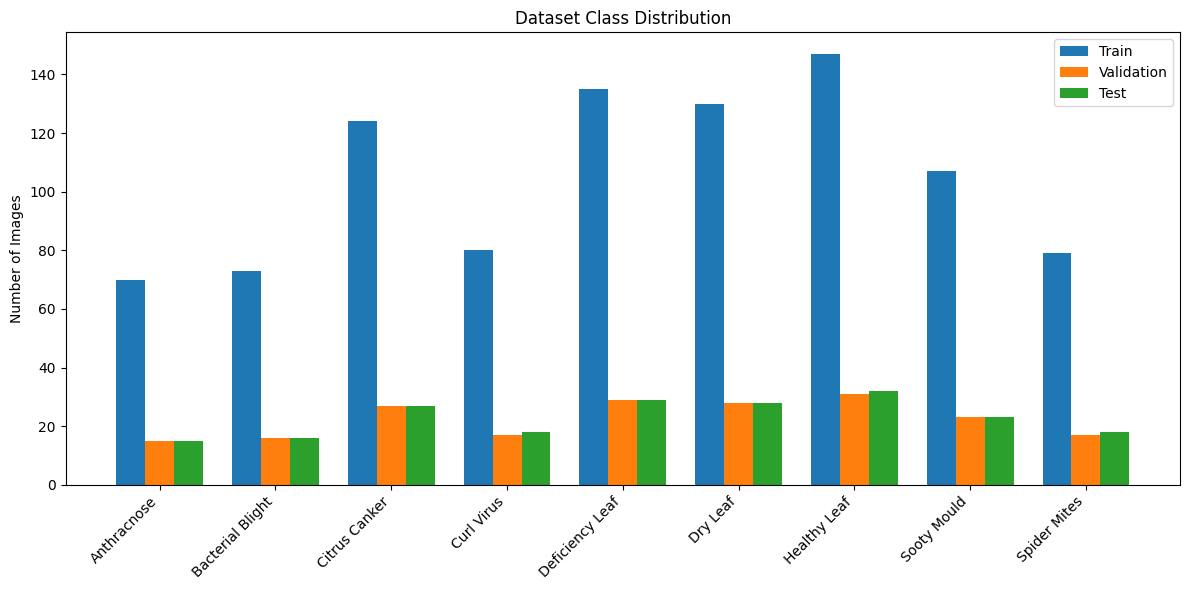

Saved class_distribution_bar_chart.png


In [5]:
import matplotlib.pyplot as plt
import numpy as np

# Data from Step 5 output
class_names = ['Anthracnose', 'Bacterial Blight', 'Citrus Canker', 'Curl Virus', 'Deficiency Leaf', 'Dry Leaf', 'Healthy Leaf', 'Sooty Mould', 'Spider Mites']
train_counts = [70, 73, 124, 80, 135, 130, 147, 107, 79]
val_counts = [15, 16, 27, 17, 29, 28, 31, 23, 17]
test_counts = [15, 16, 27, 18, 29, 28, 32, 23, 18]

x = np.arange(len(class_names))
width = 0.25

fig, ax = plt.subplots(figsize=(12, 6))
rects1 = ax.bar(x - width, train_counts, width, label='Train')
rects2 = ax.bar(x, val_counts, width, label='Validation')
rects3 = ax.bar(x + width, test_counts, width, label='Test')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Number of Images')
ax.set_title('Dataset Class Distribution')
ax.set_xticks(x)
ax.set_xticklabels(class_names, rotation=45, ha="right")
ax.legend()

fig.tight_layout()
plt.savefig("/content/class_distribution_bar_chart.png")
plt.show()

print("Saved class_distribution_bar_chart.png")

In [ ]:
# Step 6: Create tf.data datasets
IMG_HEIGHT, IMG_WIDTH = 224, 224
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    seed=123,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    label_mode='int'
)

validation_dataset = tf.keras.utils.image_dataset_from_directory(
    validation_dir,
    seed=123,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    label_mode='int'
)

test_dataset = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    shuffle=False,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    label_mode='int'
)

class_names = train_dataset.class_names
num_classes = len(class_names)
print(f"\nClass names: {class_names}")
print(f"Number of classes: {num_classes}")

# Performance
train_dataset = train_dataset.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.cache().prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.cache().prefetch(buffer_size=AUTOTUNE)


Found 945 files belonging to 9 classes.
Found 203 files belonging to 9 classes.
Found 206 files belonging to 9 classes.

Class names: ['Anthracnose', 'Bacterial Blight', 'Citrus Canker', 'Curl Virus', 'Deficiency Leaf', 'Dry Leaf', 'Healthy Leaf', 'Sooty Mould', 'Spider Mites']
Number of classes: 9


In [ ]:
# Step 6.5: Compute class weights (Optional but recommended for imbalanced datasets)
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Flatten all training labels
y_train = np.concatenate([y.numpy() for x, y in train_dataset], axis=0)

# Compute class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}
print("Class weights:", class_weight_dict)

Class weights: {0: np.float64(1.5), 1: np.float64(1.4383561643835616), 2: np.float64(0.8467741935483871), 3: np.float64(1.3125), 4: np.float64(0.7777777777777778), 5: np.float64(0.8076923076923077), 6: np.float64(0.7142857142857143), 7: np.float64(0.9813084112149533), 8: np.float64(1.3291139240506329)}


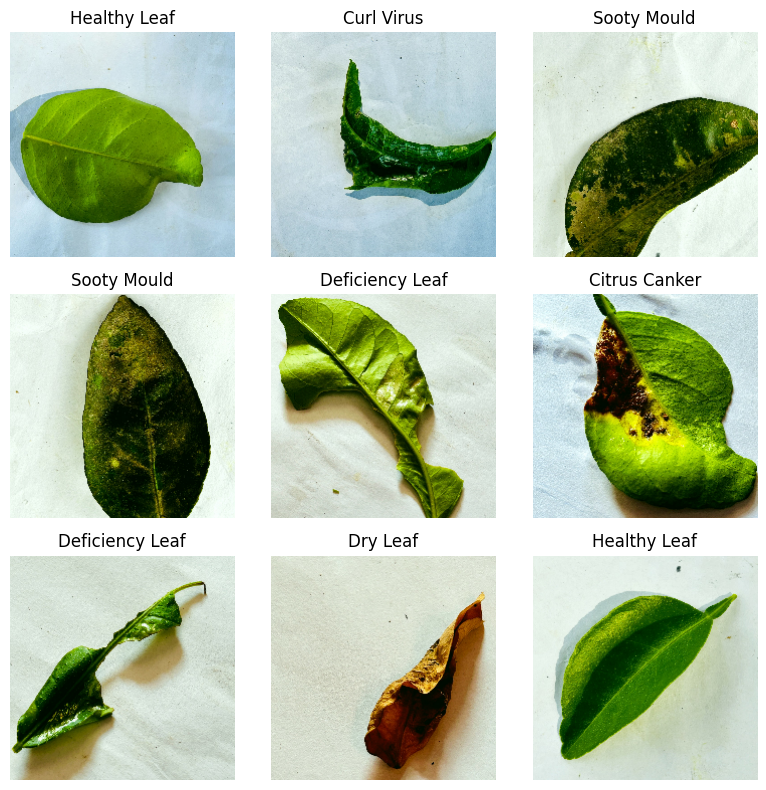

Saved sample_images.png


In [ ]:
# Step 7: Show some samples and save image
plt.figure(figsize=(8,8))
for images, labels in train_dataset.take(1):
    for i in range(min(9, images.shape[0])):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[int(labels[i])])
        plt.axis("off")
plt.tight_layout()
plt.savefig("/content/sample_images.png")
plt.show()
print("Saved sample_images.png")


In [ ]:
# Step 8: Build model with data augmentation and MobileNetV2 backbone
data_augmentation = Sequential([
    RandomFlip("horizontal_and_vertical"),
    RandomRotation(0.2),
    RandomZoom(0.2),
    RandomContrast(0.2),
], name="data_augmentation")

base_model = MobileNetV2(
    input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False  # freeze

preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

model = Sequential([
    data_augmentation,
    tf.keras.layers.Lambda(preprocess_input, name="preprocess_input"),
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.2),
    Dense(256, activation='relu'),
    Dense(num_classes, activation='softmax')
], name="mobilenetv2_transfer")

# Compile with correct metric name for checkpoints/plots
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy(name='sparse_categorical_accuracy')]
)

# --- FIX: Build the model to display proper summary ---
model.build((None, IMG_HEIGHT, IMG_WIDTH, 3))
model.summary()

# Save model summary text
with open("/content/model_summary.txt", "w") as f:
    model.summary(print_fn=lambda x: f.write(x + "\n"))

print("Model summary saved to /content/model_summary.txt")


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "mobilenetv2_transfer"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ data_augmentation (Sequential)  │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ preprocess_input (Lambda)       │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 9)              │         2,313 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,588,233 (9.87 MB)

 Trainable params: 330,249 (1.26 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

Model summary saved to /content/model_summary.txt


In [ ]:
# Visualize model architecture
plot_model(model, to_file='/content/model_architecture.png',
           show_shapes=True, show_layer_names=True, dpi=70)
print("Model architecture visualization saved to /content/model_architecture.png")

Model architecture visualization saved to /content/model_architecture.png


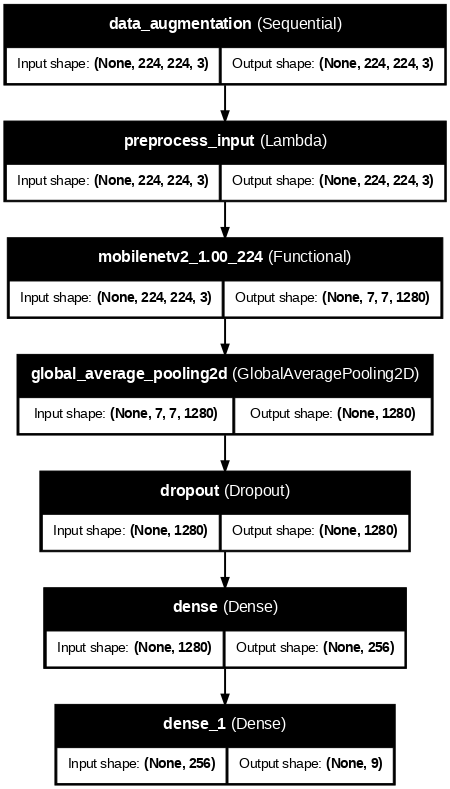

In [ ]:
from IPython.display import Image
Image(filename='/content/model_architecture.png')

In [ ]:
callbacks = [
    ModelCheckpoint('/content/best_model.keras', save_best_only=True,
                    monitor='val_sparse_categorical_accuracy', mode='max', verbose=1),
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-7, verbose=1)
]


In [ ]:
# Step 10: Train
EPOCHS = 30

history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=validation_dataset,
    callbacks=callbacks,
    class_weight=class_weight_dict  # Add this line
)

# Save final model (full model)
model.save('/content/plant_disease_model_final.keras')
print("Final model saved to /content/plant_disease_model_final.keras")

Epoch 1/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.0429 - sparse_categorical_accuracy: 0.9821
Epoch 1: val_sparse_categorical_accuracy did not improve from 0.97537
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - loss: 0.0430 - sparse_categorical_accuracy: 0.9822 - val_loss: 0.1510 - val_sparse_categorical_accuracy: 0.9606 - learning_rate: 1.6000e-06
Epoch 2/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.0406 - sparse_categorical_accuracy: 0.9923
Epoch 2: val_sparse_categorical_accuracy did not improve from 0.97537
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - loss: 0.0405 - sparse_categorical_accuracy: 0.9924 - val_loss: 0.1511 - val_sparse_categorical_accuracy: 0.9606 - learning_rate: 1.6000e-06
Epoch 3/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.0331 - sparse_categorical_accuracy: 0.9899
Epoch 3: val_sparse_categorical_accuracy did not improve from 0.97537
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - loss: 0.0330 - sparse_categorical_accuracy: 0.9898 - val_loss: 0.1513 - 

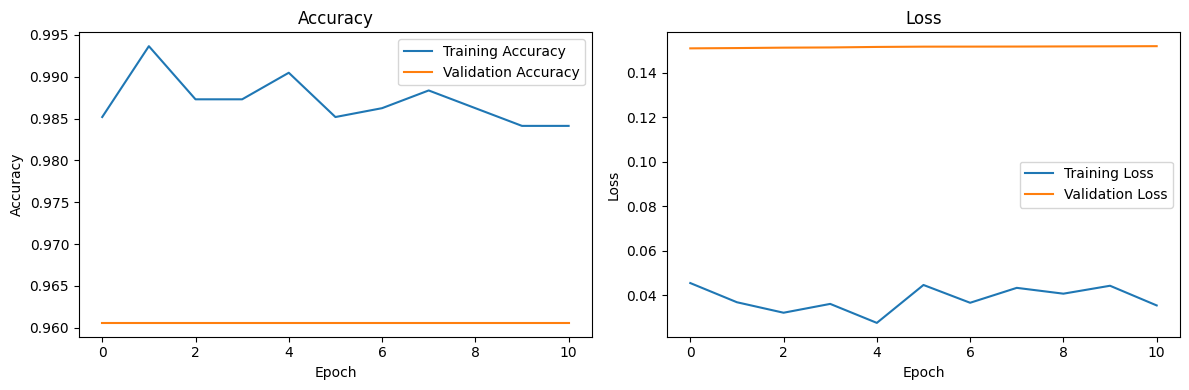

Saved training_history.png


In [ ]:
# Step 11: Plot training history
acc = history.history.get('sparse_categorical_accuracy') or history.history.get('SparseCategoricalAccuracy')
val_acc = history.history.get('val_sparse_categorical_accuracy') or history.history.get('val_SparseCategoricalAccuracy')
loss = history.history.get('loss')
val_loss = history.history.get('val_loss')

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.subplot(1,2,2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend()
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.tight_layout()
plt.savefig("/content/training_history.png")
plt.show()
print("Saved training_history.png")


In [ ]:
# Step 12: Evaluate

# Evaluate on training dataset
train_loss, train_accuracy = model.evaluate(train_dataset)
print(f"Train loss: {train_loss:.4f}")
print(f"Train accuracy: {train_accuracy * 100:.2f}%")

# Evaluate on test dataset
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"Test loss: {test_loss:.4f}")
print(f"Test accuracy: {test_accuracy * 100:.2f}%")



30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - loss: 0.0398 - sparse_categorical_accuracy: 0.9841
Train loss: 0.0383
Train accuracy: 98.62%
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.1119 - sparse_categorical_accuracy: 0.9789
Test loss: 0.1488
Test accuracy: 96.60%


In [ ]:
# Step 13: Predictions over test set
y_true = []
y_pred_probs = []

for images, labels in test_dataset:
    preds = model.predict(images, verbose=0)
    y_true.extend(labels.numpy())
    y_pred_probs.extend(preds)

y_pred = np.argmax(np.array(y_pred_probs), axis=1)
y_true = np.array(y_true)

# Classification report
print("\nClassification report:")
print(classification_report(y_true, y_pred, target_names=class_names, zero_division=0))

# Additional aggregated metrics
print("Additional metrics:")
print(f"Weighted Precision: {precision_score(y_true, y_pred, average='weighted', zero_division=0):.4f}")
print(f"Weighted Recall:    {recall_score(y_true, y_pred, average='weighted', zero_division=0):.4f}")
print(f"Weighted F1-score:  {f1_score(y_true, y_pred, average='weighted', zero_division=0):.4f}")



Classification report:
                  precision    recall  f1-score   support

     Anthracnose       0.88      1.00      0.94        15
Bacterial Blight       0.89      1.00      0.94        16
   Citrus Canker       0.96      1.00      0.98        27
      Curl Virus       0.89      0.89      0.89        18
 Deficiency Leaf       1.00      0.97      0.98        29
        Dry Leaf       1.00      1.00      1.00        28
    Healthy Leaf       1.00      0.97      0.98        32
     Sooty Mould       1.00      1.00      1.00        23
    Spider Mites       1.00      0.83      0.91        18

        accuracy                           0.97       206
       macro avg       0.96      0.96      0.96       206
    weighted avg       0.97      0.97      0.97       206

Additional metrics:
Weighted Precision: 0.9684
Weighted Recall:    0.9660
Weighted F1-score:  0.9659



=== ROC Curve and AUC Analysis ===


/tmp/ipython-input-2743435503.py:47: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('hsv', num_classes)


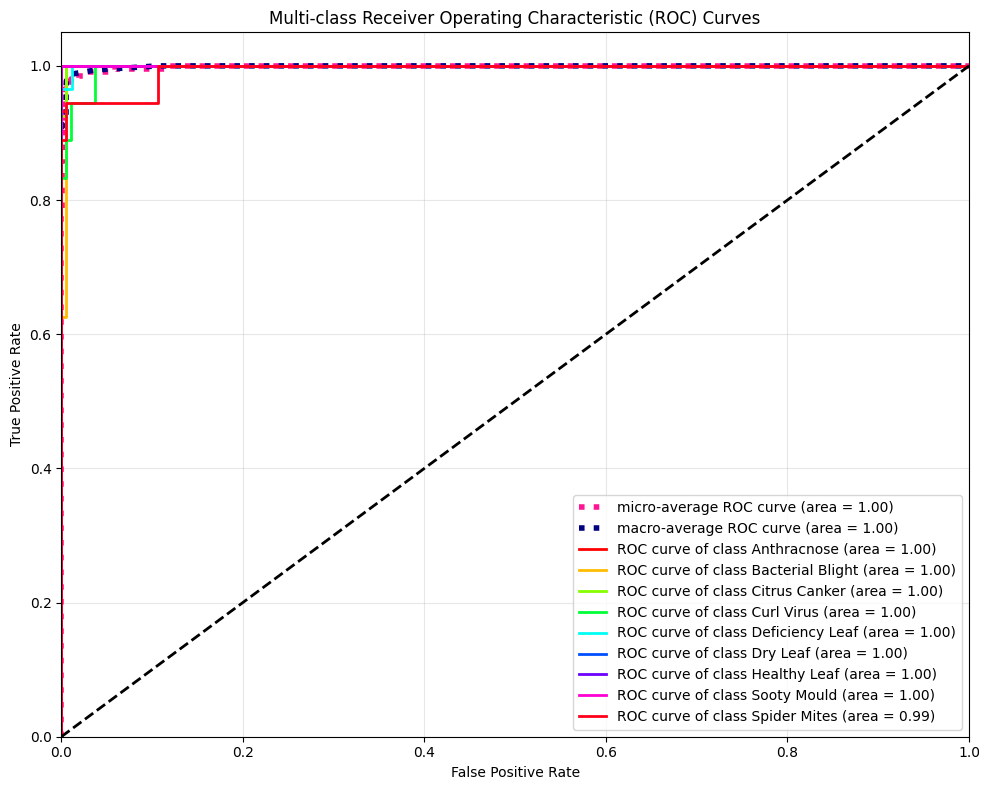

Saved ROC curves to /content/roc_curves.png

AUC Values per Class:
Anthracnose: 0.9997
Bacterial Blight: 0.9980
Citrus Canker: 0.9996
Curl Virus: 0.9970
Deficiency Leaf: 0.9996
Dry Leaf: 1.0000
Healthy Leaf: 1.0000
Sooty Mould: 1.0000
Spider Mites: 0.9938

Micro-average AUC: 0.9985
Macro-average AUC: 0.9990

=== Additional Metrics ===
Weighted F1 Score: 0.9659
Weighted Precision: 0.9684
Weighted Recall: 0.9660

Per-class Metrics:
Anthracnose: F1=0.938, Precision=0.882, Recall=1.000
Bacterial Blight: F1=0.941, Precision=0.889, Recall=1.000
Citrus Canker: F1=0.982, Precision=0.964, Recall=1.000
Curl Virus: F1=0.889, Precision=0.889, Recall=0.889
Deficiency Leaf: F1=0.982, Precision=1.000, Recall=0.966
Dry Leaf: F1=1.000, Precision=1.000, Recall=1.000
Healthy Leaf: F1=0.984, Precision=1.000, Recall=0.969
Sooty Mould: F1=1.000, Precision=1.000, Recall=1.000
Spider Mites: F1=0.909, Precision=1.000, Recall=0.833


In [ ]:
# ROC Curve and AUC Analysis
print("\n=== ROC Curve and AUC Analysis ===")

# Binarize the true labels for multi-class ROC
y_true_bin = label_binarize(y_true, classes=list(range(num_classes)))

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], np.array(y_pred_probs)[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_true_bin.ravel(), np.array(y_pred_probs).ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(num_classes)]))

# Then interpolate all ROC curves at these points
mean_tpr = np.zeros_like(all_fpr)
for i in range(num_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= num_classes
fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize=(10, 8))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = plt.cm.get_cmap('hsv', num_classes)
for i, color in zip(range(num_classes), colors(np.linspace(0, 1, num_classes))):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(class_names[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig("/content/roc_curves.png")
plt.show()
print("Saved ROC curves to /content/roc_curves.png")

# Print AUC values
print("\nAUC Values per Class:")
for i, class_name in enumerate(class_names):
    print(f"{class_name}: {roc_auc[i]:.4f}")

print(f"\nMicro-average AUC: {roc_auc['micro']:.4f}")
print(f"Macro-average AUC: {roc_auc['macro']:.4f}")

# Additional Metrics Calculation
from sklearn.metrics import f1_score, precision_score, recall_score

# Calculate additional metrics
f1 = f1_score(y_true, y_pred, average='weighted')
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')

print("\n=== Additional Metrics ===")
print(f"Weighted F1 Score: {f1:.4f}")
print(f"Weighted Precision: {precision:.4f}")
print(f"Weighted Recall: {recall:.4f}")

# Calculate per-class metrics
f1_per_class = f1_score(y_true, y_pred, average=None)
precision_per_class = precision_score(y_true, y_pred, average=None)
recall_per_class = recall_score(y_true, y_pred, average=None)

print("\nPer-class Metrics:")
for i, class_name in enumerate(class_names):
    print(f"{class_name}: F1={f1_per_class[i]:.3f}, Precision={precision_per_class[i]:.3f}, Recall={recall_per_class[i]:.3f}")

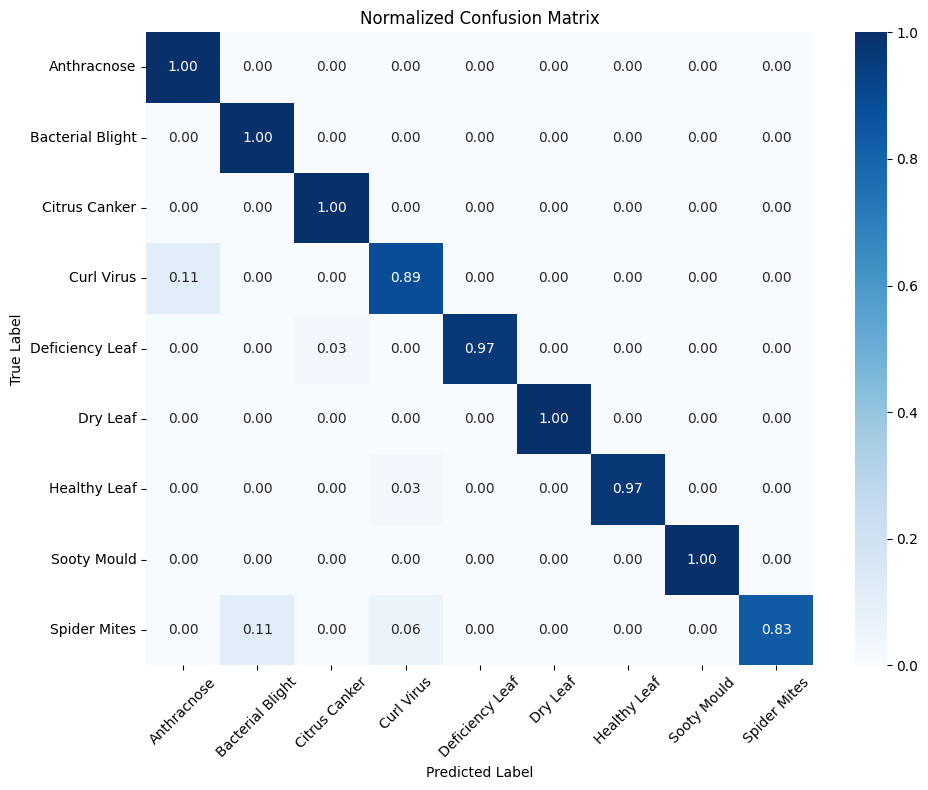

Saved confusion_matrix_overall.png


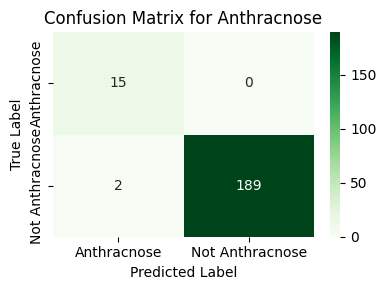

Saved confusion_matrix_Anthracnose.png


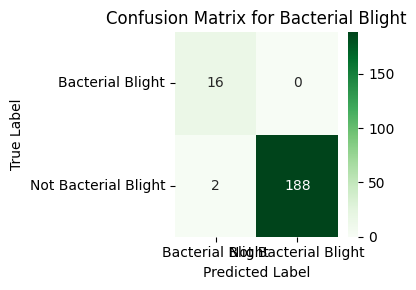

Saved confusion_matrix_Bacterial Blight.png


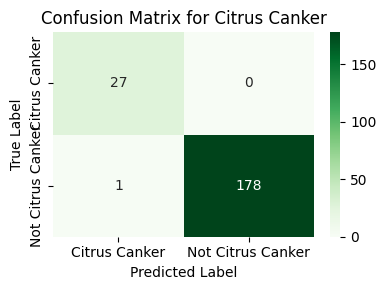

Saved confusion_matrix_Citrus Canker.png


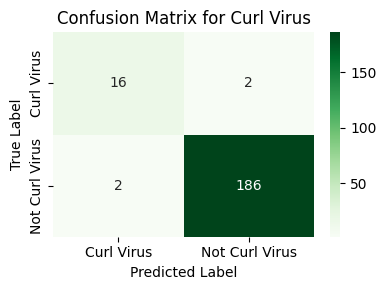

Saved confusion_matrix_Curl Virus.png


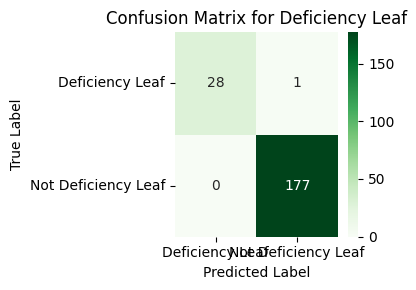

Saved confusion_matrix_Deficiency Leaf.png


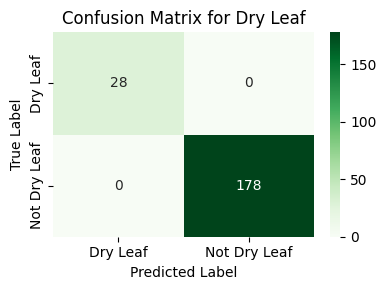

Saved confusion_matrix_Dry Leaf.png


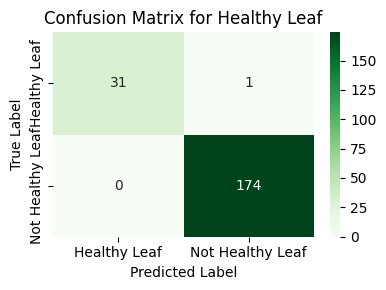

Saved confusion_matrix_Healthy Leaf.png


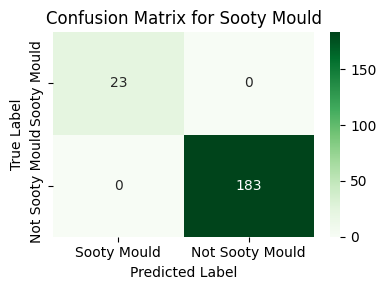

Saved confusion_matrix_Sooty Mould.png


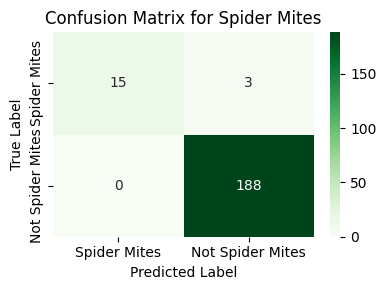

Saved confusion_matrix_Spider Mites.png


In [ ]:
# Step 14a: Confusion Matrices

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Compute full confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot and save overall confusion matrix (normalized for clarity)
plt.figure(figsize=(10,8))
sns.heatmap(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis],
            annot=True, fmt=".2f", cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.title("Normalized Confusion Matrix")
plt.tight_layout()
plt.savefig("/content/confusion_matrix_overall.png")
plt.show()
print("Saved confusion_matrix_overall.png")

# Generate separate confusion matrix for each class (One-vs-All)
for i, class_name in enumerate(class_names):
    cm_class = np.zeros((2, 2), dtype=int)
    cm_class[0, 0] = cm[i, i]  # True Positives
    cm_class[0, 1] = cm[i, :].sum() - cm[i, i]  # False Negatives
    cm_class[1, 0] = cm[:, i].sum() - cm[i, i]  # False Positives
    cm_class[1, 1] = cm.sum() - cm[i, :].sum() - cm[:, i].sum() + cm[i, i]  # True Negatives

    plt.figure(figsize=(4, 3))
    sns.heatmap(cm_class, annot=True, fmt='d', cmap='Greens',
                xticklabels=[f"{class_name}", f"Not {class_name}"],
                yticklabels=[f"{class_name}", f"Not {class_name}"])
    plt.title(f"Confusion Matrix for {class_name}")
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.tight_layout()
    plt.savefig(f"/content/confusion_matrix_{class_name}.png")
    plt.show()
    print(f"Saved confusion_matrix_{class_name}.png")


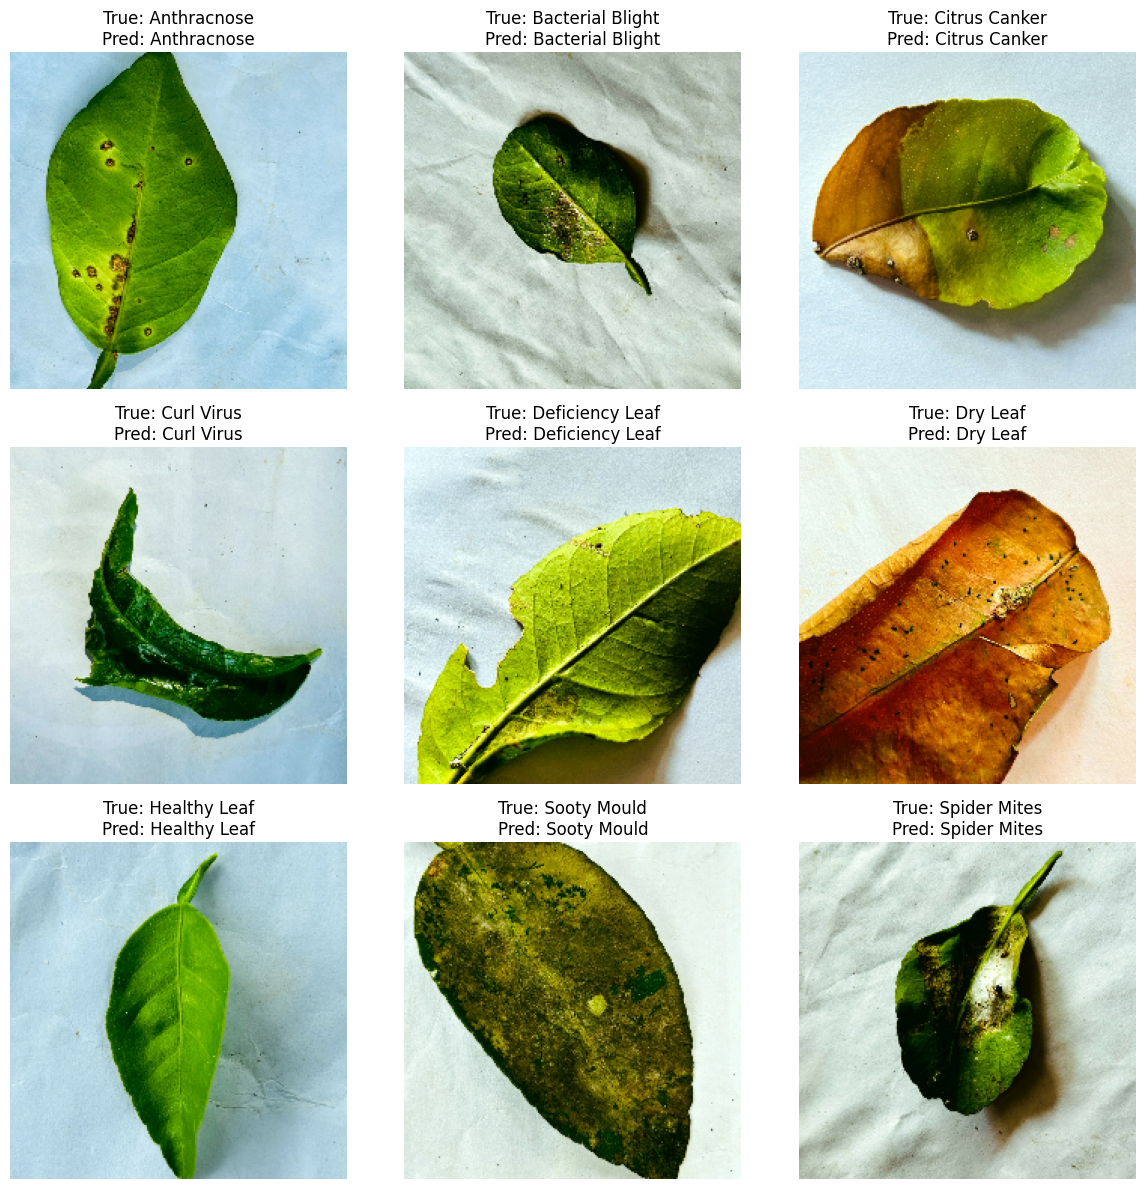

Saved predictions_per_class.png


In [ ]:
# Step 14b (updated): Visualize one prediction per class

# Convert dataset to lists for easy indexing
images_list = []
labels_list = []
for img, lab in test_dataset.unbatch():
    images_list.append(img.numpy().astype('uint8'))
    labels_list.append(int(lab.numpy()))

images_list = np.array(images_list)
labels_list = np.array(labels_list)

# Dictionary to store first occurrence of each class
class_examples = {}
for i, (img, lab) in enumerate(zip(images_list, labels_list)):
    if lab not in class_examples:  # only keep first example per class
        class_examples[lab] = (img, y_pred[i])
    if len(class_examples) == len(class_names):  # collected all classes
        break

# Plot one example per class
plt.figure(figsize=(12, 12))
for idx, (lab, (img, pred)) in enumerate(class_examples.items()):
    ax = plt.subplot(int(np.ceil(len(class_examples)/3)), 3, idx+1)
    plt.imshow(img)
    true_label = class_names[lab]
    pred_label = class_names[pred]
    plt.title(f"True: {true_label}\nPred: {pred_label}")
    plt.axis('off')

plt.tight_layout()
plt.savefig("/content/predictions_per_class.png")
plt.show()
print("Saved predictions_per_class.png")
